In [7]:
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy
from scipy import sparse

In [8]:
def GeraRede(n,m,CH,CV):
    nv = n*m
    nc = (n-1)*m + (m-1)*n
    
    coord = np.zeros(shape=(nv,2))

    for i in range(n):
      for j in range(m):
        ig = i + j*n
        coord[ig,0] = i
        coord[ig,1] = j

    conec = np.zeros(shape=(nc,2), dtype=int)
    C = np.zeros(nc)
    
    # Loop sobre canos horizontais
    for j in range(m):
        for i in range(n-1):
          k = j*(n-1) + i
          conec[k,0] = j*n + i
          conec[k,1] = j*n + i+1
          C[k] = CH

    # Loop sobre canos verticais
    for i in range(n):
      for j in range(m-1):
          k = (n-1)*m + j*n + i
          conec[k,0] = i + j*n
          conec[k,1] = i + (j+1)*n
          C[k] = CV

    return nv, nc, conec, C, coord

In [9]:
def PlotPressure(m, n, pressure):
    x = np.arange(0, m, 1)
    y = np.arange(0, n, 1)
    X,Y=np.meshgrid(x,y)
    Z = np.copy(pressure)
    Z.shape = (n,m)
    fig, ax = plt.subplots(figsize=(10,10))
    ax.set_aspect('equal')
    ax.set(xlabel='x', ylabel='y', title='Contours of pressure')
    ax.grid()
    ax.set_xticks(x)
    ax.set_yticks(y)
    cp = plt.contourf(X, Y, Z, cmap='jet')
    cb = plt.colorbar(cp)
    plt.show()

def PlotPressureAsSurface(m, n, pressure):
    x = np.arange(0, m, 1)
    y = np.arange(0, n, 1)
    X,Y=np.meshgrid(x,y)
    Z = np.copy(pressure)
    Z.shape = (n,m)
    fig, ax = plt.subplots(figsize=(10,10))
    ax.set_aspect('equal')
    ax.set(xlabel='x', ylabel='y', title='Contours of pressure')
    ax.grid()
    ax.set_xticks(x)
    ax.set_yticks(y)
    ax = plt.axes(projection="3d")
    ax.plot_surface(X, Y, Z, cmap='jet', edgecolor=None)
    ax.set(xlabel='$x$', ylabel='$y$', zlabel='$z$')
    ax.view_init(elev=30., azim=45)
    plt.show()

In [10]:
#Exercício 1
def Assembly(conec, C):
    nc = conec.shape[0]
    nv = conec[0,0]
    for i in range(nc):
        for j in range(2):
            if conec[i, j] > nv:
                nv = conec[i,j]
    nv += 1
    A = np.zeros(shape=(nv, nv))

    for j in range(nc):
        A[conec[j, 0], conec[j, 0]] += C[j]
        A[conec[j, 1], conec[j, 1]] += C[j]
        A[conec[j, 0], conec[j, 1]] -= C[j]
        A[conec[j, 1], conec[j, 0]] -= C[j]

    return A

In [17]:
#Exercício 2
def SolveNetwork(conec, natm, nb, Qb, C):
    Atil = Assembly(conec, C)
    aux = np.zeros(shape=Atil.shape[1])
    aux[natm] = 1
    Atil[natm] = aux
    Atil_aux = scipy.sparse.csr_matrix(Atil)

    b = np.zeros(shape=Atil.shape[0])
    b[nb] = Qb

    

    pressure = sparse.linalg.spsolve(Atil_aux, b)
    return pressure
    

In [15]:
#Exercício 3
def CalculaVazoes(C, conec, p, nc, nv):
    #Calculo de K
    K = np.zeros(shape=(nc, nc))
    for i in range(nc):
        K[i, i] = C[i]

    #Calculo de D
    D = np.zeros(shape=(nc, nv))
    for i in range(nc):
        for j in range(nv):
            D[i, conec[i, 0]] = 1
            D[i, conec[i, 1]] = -1

    Q = K@D@p
    return Q

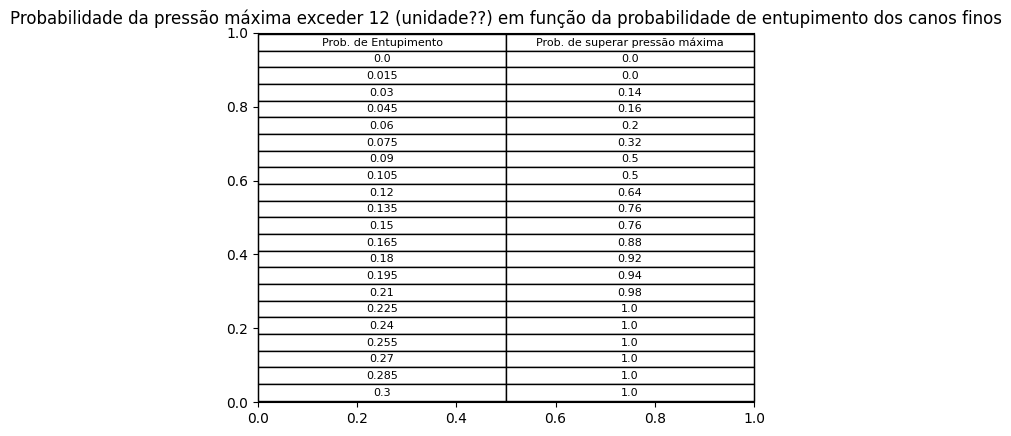

In [31]:
#Calculo da probabilidade

#Função chance de finos entupir
def RandomFailFinos(C, prob0, Centup):
    Cnew = np.copy(C)
    nc = C.shape[0]

    for i in range(nc):
        x = np.random.rand()
        if(x<=prob0 and C[i]==2.0):
            Cnew[i] = Centup

    return Cnew

#Função retorna probabilidade da pressão máxima na rede exceder a pressão máxima limite (pré-determinada)
def ProbOverPressMax(pressureMax, prob0):
    count_overflow = 0
    for i in range(nTestes):
        Cnew = RandomFailFinos(C, prob0, Centup)
        A = Assembly(conec, Cnew)
        pressure = SolveNetwork(conec, natm, nb, Qb, Cnew)
        pm = np.max(pressure)
        if pm > pressureMax:
            count_overflow += 1
    probFinal = count_overflow/nTestes
    return probFinal

#Definições e geração da rede
nx = 10 #Número de nós horizontais
ny = 10 #Número de nós verticais
CH = 2. 
CV = 2.0

natm = nx*ny-1
nb = 0
Qb = 10

pressureMax = 12 #Pressão máxima limite (parâmetro)

nv, nc, conec, C, coord = GeraRede(nx, ny, CH, CV)

#Alteração de C (inclusão dos canos grossos)
lst = [0, 1, 2, 30, 31, 32, 93, 103, 113]
C[lst] = 20.0

nTestes = 50 # numero de testes
count_overflow = 0 # numero de casos em que a pressão foi maior que 12
Centup = 0.2 # Condutividade do cano entupido

# Definições do conjunto de dados e plotagem

quant = 21 # Quantidade de testes
relacao = np.zeros(shape=(quant, 2))
probs = np.linspace(0.0, 0.3, quant)
colunas = ('Prob. de Entupimento', 'Prob. de superar pressão máxima')

# Cálculo da probabilidade da pressão máxima na rede exceder a pressão máxima pré-determinada para (quant) valores de probabilidade de entupimento do cano

for i in range(quant):
    prob_atual = round(probs[i], 3)
    aux = ProbOverPressMax(pressureMax, prob_atual)
    relacao[i, 0] = prob_atual
    relacao[i, 1] = aux

plt.title("Tabela da prob. da pressão máxima exceder {} em função da prob. de entupimento dos canos finos".format(pressureMax))
plt.table(cellText=relacao, colLabels=colunas, loc='center', colLoc='center', cellLoc='center')


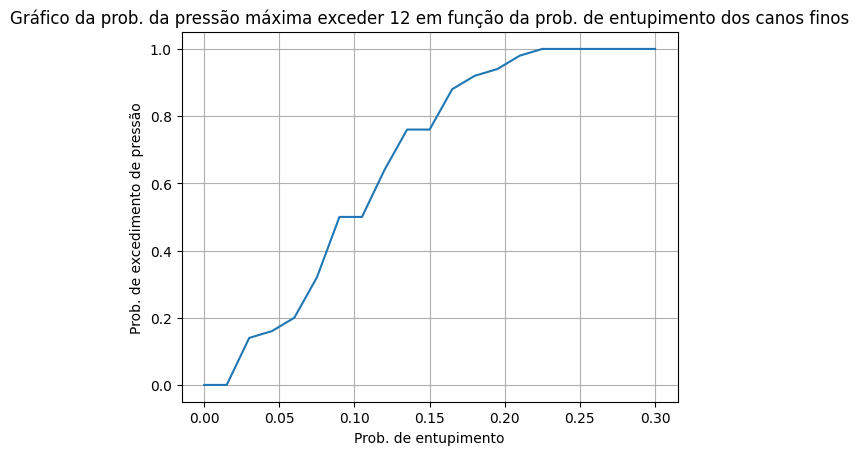

In [35]:
plt.title("Gráfico da prob. da pressão máxima exceder {} em função da prob. de entupimento dos canos finos".format(pressureMax))
plt.grid()
plt.plot(relacao[:,0], relacao[:,1])
plt.xlabel("Prob. de entupimento")
plt.ylabel("Prob. de excedimento de pressão")
plt.show()